# Change Point Index Creator and Day Splitter

In [1]:
import pandas as pd
import os
import sys
sys.path.append("..")

os.chdir("..")
# List all CSV files in the data/raw directory
csv_files = [f for f in os.listdir('data/raw') if f.endswith('.csv')]

# ,date,sender_id,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend
# Define the columns to load
columns_to_load = ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob','dose_units','food_g','food_glycemic_index']

# Load each CSV file into a DataFrame and store them in a dictionary
dataframes = {file: pd.read_csv(os.path.join('data/raw', file), usecols=columns_to_load, parse_dates=['date']) for file in csv_files}

# Print the names of the loaded DataFrames
print("Loaded DataFrames:", list(dataframes.keys()))

Loaded DataFrames: ['500030_2024-07-01_2024-09-30.csv', '679372_2024-07-01_2024-09-30.csv']


In [ ]:
cr_df = dataframes['679372_2024-07-01_2024-09-30.csv']
cr_df.head()

,date,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
0,2024-07-01 00:02:32-04:00,115.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-07-01 00:05:33-04:00,112.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-07-01 00:08:33-04:00,116.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-07-01 00:10:34-04:00,121.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-07-01 00:13:36-04:00,122.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
cr_df[cr_df['msg_type'] == 'ANNOUNCE_MEAL']

,date,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
256,2024-07-01 13:39:01.062000-04:00,135.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
275,2024-07-01 14:32:31.740000-04:00,157.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
308,2024-07-01 15:44:35.026000-04:00,223.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
718,2024-07-02 13:19:08.176000-04:00,102.0,ANNOUNCE_MEAL,True,False,0.0,40.0,0.5
849,2024-07-02 20:12:00.212000-04:00,97.0,ANNOUNCE_MEAL,True,False,NaN,15.0,0.5
...,...,...,...,...,...,...,...,...
39619,2024-09-29 20:44:47.993000-04:00,69.0,ANNOUNCE_MEAL,True,False,NaN,12.0,0.5
39620,2024-09-29 20:46:03.006000-04:00,69.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5
39641,2024-09-29 21:32:43.092000-04:00,89.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5
39920,2024-09-30 14:18:29.569000-04:00,132.0,ANNOUNCE_MEAL,True,False,NaN,10.0,0.5


In [4]:
cr_df = cr_df.set_index('date').squeeze()
cr_df.index = pd.DatetimeIndex(cr_df.index)

In [5]:
meal_annoucements_df = cr_df[cr_df['msg_type'] == 'ANNOUNCE_MEAL']
meal_annoucements_df


,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
date,,,,,,,
2024-07-01 13:39:01.062000-04:00,135.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-01 14:32:31.740000-04:00,157.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-01 15:44:35.026000-04:00,223.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-02 13:19:08.176000-04:00,102.0,ANNOUNCE_MEAL,True,False,0.0,40.0,0.5
2024-07-02 20:12:00.212000-04:00,97.0,ANNOUNCE_MEAL,True,False,NaN,15.0,0.5
...,...,...,...,...,...,...,...
2024-09-29 20:44:47.993000-04:00,69.0,ANNOUNCE_MEAL,True,False,NaN,12.0,0.5
2024-09-29 20:46:03.006000-04:00,69.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5
2024-09-29 21:32:43.092000-04:00,89.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5


In [6]:
meal_annoucements_df = meal_annoucements_df.resample('5min').first()
meal_annoucements_df

,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
date,,,,,,,
2024-07-01 13:35:00-04:00,135.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-01 13:40:00-04:00,NaN,None,None,None,NaN,NaN,NaN
2024-07-01 13:45:00-04:00,NaN,None,None,None,NaN,NaN,NaN
2024-07-01 13:50:00-04:00,NaN,None,None,None,NaN,NaN,NaN
2024-07-01 13:55:00-04:00,NaN,None,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-09-30 17:45:00-04:00,NaN,None,None,None,NaN,NaN,NaN
2024-09-30 17:50:00-04:00,NaN,None,None,None,NaN,NaN,NaN
2024-09-30 17:55:00-04:00,NaN,None,None,None,NaN,NaN,NaN


In [7]:
meal_annoucements_df = meal_annoucements_df[meal_annoucements_df['msg_type'] == 'ANNOUNCE_MEAL']
meal_annoucements_df

,bgl,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index
date,,,,,,,
2024-07-01 13:35:00-04:00,135.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-01 14:30:00-04:00,157.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-01 15:40:00-04:00,223.0,ANNOUNCE_MEAL,True,False,0.0,22.0,0.5
2024-07-02 13:15:00-04:00,102.0,ANNOUNCE_MEAL,True,False,0.0,40.0,0.5
2024-07-02 20:10:00-04:00,97.0,ANNOUNCE_MEAL,True,False,NaN,15.0,0.5
...,...,...,...,...,...,...,...
2024-09-29 20:40:00-04:00,71.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5
2024-09-29 20:45:00-04:00,69.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5
2024-09-29 21:30:00-04:00,89.0,ANNOUNCE_MEAL,True,False,NaN,6.0,0.5


In [8]:
non_meal_df = cr_df[cr_df['msg_type'] != 'ANNOUNCE_MEAL']
non_meal_df = non_meal_df.resample('5min').first()

cr_resampled = non_meal_df.join(meal_annoucements_df, how='left', rsuffix='_meal')

print(cr_resampled[cr_resampled['msg_type_meal'] == 'ANNOUNCE_MEAL'])


                             bgl      msg_type affects_fob affects_iob  \
date                                                                     
2024-07-01 13:35:00-04:00  135.0  DOSE_INSULIN       False        True   
2024-07-01 14:30:00-04:00  157.0          None        None        None   
2024-07-01 15:40:00-04:00  223.0          None        None        None   
2024-07-02 13:15:00-04:00  102.0          None        None        None   
2024-07-02 20:10:00-04:00   97.0  DOSE_INSULIN       False        True   
...                          ...           ...         ...         ...   
2024-09-29 20:40:00-04:00   71.0          None        None        None   
2024-09-29 20:45:00-04:00   68.0          None        None        None   
2024-09-29 21:30:00-04:00   89.0          None        None        None   
2024-09-30 14:15:00-04:00  132.0  DOSE_INSULIN       False        True   
2024-09-30 18:05:00-04:00   92.0          None        None        None   

                           dose_units

In [9]:
cr_resampled.loc['2024-07-01 14:30:00-04:05']

bgl                         159.0
msg_type                     None
affects_fob                  None
affects_iob                  None
dose_units                    NaN
food_g                        NaN
food_glycemic_index           NaN
bgl_meal                      NaN
msg_type_meal                 NaN
affects_fob_meal              NaN
affects_iob_meal              NaN
dose_units_meal               NaN
food_g_meal                   NaN
food_glycemic_index_meal      NaN
Name: 2024-07-01 14:35:00-04:00, dtype: object

In [10]:
# Create the new 'bgl' column
cr_resampled['bgl'] = cr_resampled['bgl_meal'].combine_first(cr_resampled['bgl'])

# Drop the 'bgl_meal' column if it's no longer needed
cr_resampled.drop(columns=['bgl_meal'], inplace=True)

# Display the updated DataFrame
print(cr_resampled)

                             bgl msg_type affects_fob affects_iob  dose_units  \
date                                                                            
2024-07-01 00:00:00-04:00  115.0     None        None        None         NaN   
2024-07-01 00:05:00-04:00  112.0     None        None        None         NaN   
2024-07-01 00:10:00-04:00  121.0     None        None        None         NaN   
2024-07-01 00:15:00-04:00  118.0     None        None        None         NaN   
2024-07-01 00:20:00-04:00  115.0     None        None        None         NaN   
...                          ...      ...         ...         ...         ...   
2024-09-30 23:35:00-04:00  113.0     None        None        None         NaN   
2024-09-30 23:40:00-04:00  112.0     None        None        None         NaN   
2024-09-30 23:45:00-04:00  101.0     None        None        None         NaN   
2024-09-30 23:50:00-04:00   96.0     None        None        None         NaN   
2024-09-30 23:55:00-04:00  1

In [ ]:
# Iterate through the DataFrame and update the 'msg_type_meal' column
for idx in meal_annoucements_df.index:
    if meal_annoucements_df.at[idx, 'msg_type'] == 'ANNOUNCE_MEAL':

        end_time = idx + pd.Timedelta(hours=2)
        if end_time in cr_resampled.index:
            cr_resampled.at[idx, 'msg_type'] = 'ANNOUNCE_MEAL'
            cr_resampled.at[end_time, 'msg_type'] = 'MEAL_END'

# Display the updated DataFrame
print(cr_resampled)

                             bgl msg_type affects_fob affects_iob  dose_units  \
date                                                                            
2024-07-01 00:00:00-04:00  115.0     None        None        None         NaN   
2024-07-01 00:05:00-04:00  112.0     None        None        None         NaN   
2024-07-01 00:10:00-04:00  121.0     None        None        None         NaN   
2024-07-01 00:15:00-04:00  118.0     None        None        None         NaN   
2024-07-01 00:20:00-04:00  115.0     None        None        None         NaN   
...                          ...      ...         ...         ...         ...   
2024-09-30 23:35:00-04:00  113.0     None        None        None         NaN   
2024-09-30 23:40:00-04:00  112.0     None        None        None         NaN   
2024-09-30 23:45:00-04:00  101.0     None        None        None         NaN   
2024-09-30 23:50:00-04:00   96.0     None        None        None         NaN   
2024-09-30 23:55:00-04:00  1

In [12]:
cr_resampled.loc['2024-07-02 20:10:00-04:00']

bgl                                  97.0
msg_type                    ANNOUNCE_MEAL
affects_fob                         False
affects_iob                          True
dose_units                            1.0
food_g                                NaN
food_glycemic_index                   NaN
msg_type_meal               ANNOUNCE_MEAL
affects_fob_meal                     True
affects_iob_meal                    False
dose_units_meal                       NaN
food_g_meal                          15.0
food_glycemic_index_meal              0.5
Name: 2024-07-02 20:10:00-04:00, dtype: object

In [13]:
timezone = cr_resampled.index.tz
print(f"Timezone: {timezone}")

Timezone: UTC-04:00


In [14]:
cr_resampled['adjusted_date'] = cr_resampled.index - pd.Timedelta(hours=4)
cr_resampled['day_4am'] = cr_resampled['adjusted_date'].dt.date
print(cr_resampled['day_4am'][:400])

date
2024-07-01 00:00:00-04:00    2024-06-30
2024-07-01 00:05:00-04:00    2024-06-30
2024-07-01 00:10:00-04:00    2024-06-30
2024-07-01 00:15:00-04:00    2024-06-30
2024-07-01 00:20:00-04:00    2024-06-30
                                ...    
2024-07-02 08:55:00-04:00    2024-07-02
2024-07-02 09:00:00-04:00    2024-07-02
2024-07-02 09:05:00-04:00    2024-07-02
2024-07-02 09:10:00-04:00    2024-07-02
2024-07-02 09:15:00-04:00    2024-07-02
Freq: 5min, Name: day_4am, Length: 400, dtype: object


In [15]:
cr_resampled = cr_resampled.drop(columns=['affects_fob', 'affects_iob', 'food_glycemic_index', 'adjusted_date', 'msg_type_meal','affects_iob_meal', 'dose_units_meal', 'food_g_meal', 'affects_fob_meal','food_glycemic_index_meal'])

In [16]:
grouped = cr_resampled.groupby('day_4am')
for day, group in grouped:

    if len(group) < 288:
        print(f"Day: {day}")
        print(len(group))

Day: 2024-06-30
48
Day: 2024-09-30
240


In [17]:
from datetime import datetime
cr_resampled['day_4am'] = pd.to_datetime(cr_resampled['day_4am'])
condition1 = cr_resampled['day_4am'] == pd.Timestamp(datetime(2024, 9, 30))
condition2 = cr_resampled['day_4am'] == pd.Timestamp(datetime(2024, 6, 30))
condition = condition1 | condition2
condition

date
2024-07-01 00:00:00-04:00    True
2024-07-01 00:05:00-04:00    True
2024-07-01 00:10:00-04:00    True
2024-07-01 00:15:00-04:00    True
2024-07-01 00:20:00-04:00    True
                             ... 
2024-09-30 23:35:00-04:00    True
2024-09-30 23:40:00-04:00    True
2024-09-30 23:45:00-04:00    True
2024-09-30 23:50:00-04:00    True
2024-09-30 23:55:00-04:00    True
Freq: 5min, Name: day_4am, Length: 26496, dtype: bool

In [18]:
# Drop rows based on the combined condition
cr_resampled_filtered = cr_resampled.drop(cr_resampled[condition].index)

# Print the resulting DataFrame
print(cr_resampled_filtered)

                             bgl msg_type  dose_units  food_g    day_4am
date                                                                    
2024-07-01 04:00:00-04:00  112.0     None         NaN     NaN 2024-07-01
2024-07-01 04:05:00-04:00  106.0     None         NaN     NaN 2024-07-01
2024-07-01 04:10:00-04:00  105.0     None         NaN     NaN 2024-07-01
2024-07-01 04:15:00-04:00  107.0     None         NaN     NaN 2024-07-01
2024-07-01 04:20:00-04:00  107.0     None         NaN     NaN 2024-07-01
...                          ...      ...         ...     ...        ...
2024-09-30 03:35:00-04:00  129.0     None         NaN     NaN 2024-09-29
2024-09-30 03:40:00-04:00  118.0     None         NaN     NaN 2024-09-29
2024-09-30 03:45:00-04:00  122.0     None         NaN     NaN 2024-09-29
2024-09-30 03:50:00-04:00  126.0     None         NaN     NaN 2024-09-29
2024-09-30 03:55:00-04:00  133.0     None         NaN     NaN 2024-09-29

[26208 rows x 5 columns]


In [19]:
cr_resampled_filtered.index

DatetimeIndex(['2024-07-01 04:00:00-04:00', '2024-07-01 04:05:00-04:00',
               '2024-07-01 04:10:00-04:00', '2024-07-01 04:15:00-04:00',
               '2024-07-01 04:20:00-04:00', '2024-07-01 04:25:00-04:00',
               '2024-07-01 04:30:00-04:00', '2024-07-01 04:35:00-04:00',
               '2024-07-01 04:40:00-04:00', '2024-07-01 04:45:00-04:00',
               ...
               '2024-09-30 03:10:00-04:00', '2024-09-30 03:15:00-04:00',
               '2024-09-30 03:20:00-04:00', '2024-09-30 03:25:00-04:00',
               '2024-09-30 03:30:00-04:00', '2024-09-30 03:35:00-04:00',
               '2024-09-30 03:40:00-04:00', '2024-09-30 03:45:00-04:00',
               '2024-09-30 03:50:00-04:00', '2024-09-30 03:55:00-04:00'],
              dtype='datetime64[ns, UTC-04:00]', name='date', length=26208, freq=None)

In [21]:
# Assuming cr_resampled_filtered is your DataFrame

# Create a new integer index starting at 0
new_index = pd.RangeIndex(start=0, stop=len(cr_resampled_filtered), step=1, dtype='int32')

# Set the new integer index to the DataFrame
cr_resampled_filtered.index = new_index

# Now the index is an integer index starting at 0 and of type int32
print(cr_resampled_filtered.index)

RangeIndex(start=0, stop=26208, step=1)


Create first week as a subset.

In [22]:
three_days = cr_resampled_filtered[:288*3]

In [23]:
ts = three_days['bgl']
ts

0      112.0
1      106.0
2      105.0
3      107.0
4      107.0
       ...  
859    117.0
860    116.0
861    116.0
862    116.0
863    115.0
Name: bgl, Length: 864, dtype: float64

In [24]:
condition1 = three_days['msg_type'] == 'MEAL_END'
condition2 = three_days['msg_type'] == 'ANNOUNCE_MEAL'
condition = condition1 | condition2
true_cps = ts[condition].index
true_cps

Index([115, 126, 139, 140, 150, 164, 399, 423, 482, 503, 506, 527, 646, 670,
       698, 722, 757, 771, 781, 795],
      dtype='int64')

In [25]:
import sys

sys.path.insert(0, "..")

import pandas as pd
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes
from sktime.annotation.plotting.utils import (
    plot_time_series_with_change_points,
    plot_time_series_with_profiles,
)
from sktime.datasets import load_electric_devices_segmentation

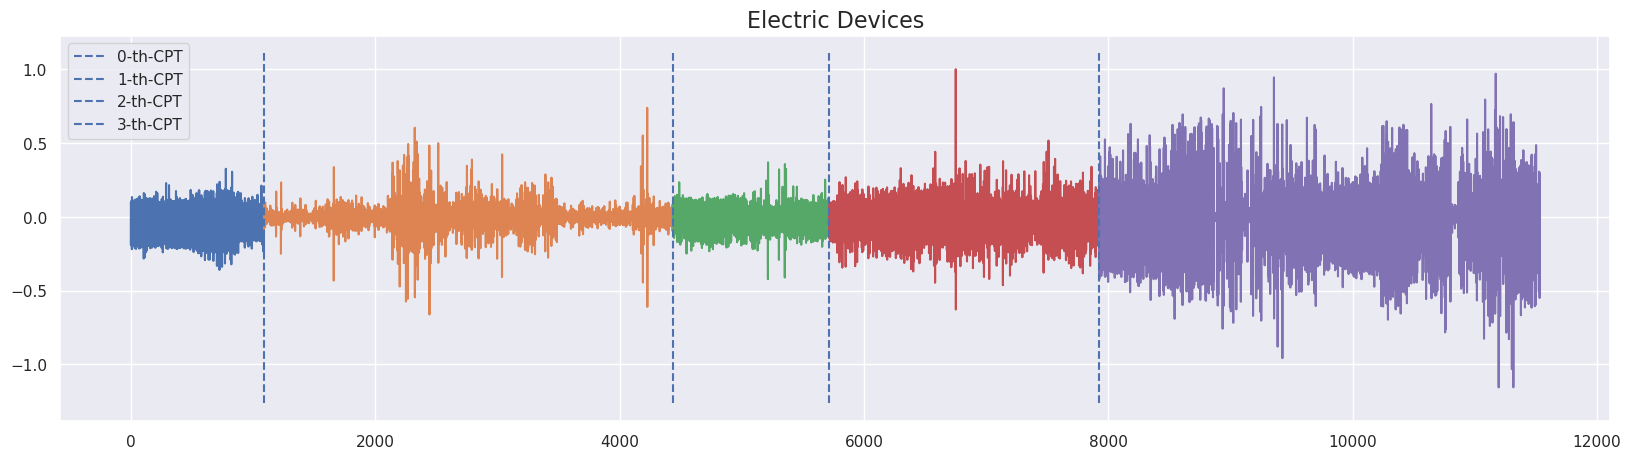

In [26]:
ts_ex, period_size_ex, true_cps_ex = load_electric_devices_segmentation()
_ = plot_time_series_with_change_points("Electric Devices", ts_ex, true_cps_ex)


In [27]:
ts_ex

1       -0.187086
2        0.098119
3        0.088967
4        0.107328
5       -0.193514
           ...   
11528    0.300240
11529    0.200745
11530   -0.548908
11531    0.274886
11532    0.274022
Name: 1, Length: 11532, dtype: float64

In [28]:
true_cps_ex

array([1090, 4436, 5712, 7923], dtype=int32)

In [29]:
ts

0      112.0
1      106.0
2      105.0
3      107.0
4      107.0
       ...  
859    117.0
860    116.0
861    116.0
862    116.0
863    115.0
Name: bgl, Length: 864, dtype: float64

In [30]:
true_cps

Index([115, 126, 139, 140, 150, 164, 399, 423, 482, 503, 506, 527, 646, 670,
       698, 722, 757, 771, 781, 795],
      dtype='int64')

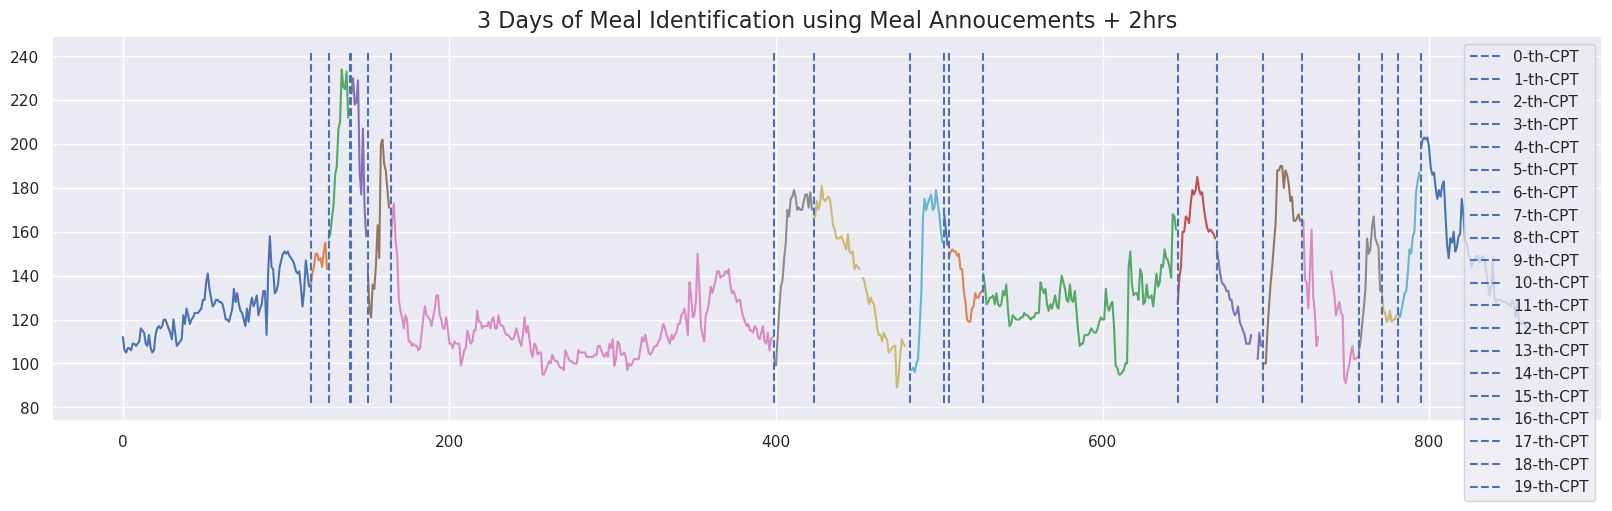

In [33]:
_ = plot_time_series_with_change_points("3 Days of Meal Identification using Meal Annoucements + 2hrs", ts, true_cps)

In [27]:
ts_ex

1       -0.187086
2        0.098119
3        0.088967
4        0.107328
5       -0.193514
           ...   
11528    0.300240
11529    0.200745
11530   -0.548908
11531    0.274886
11532    0.274022
Name: 1, Length: 11532, dtype: float64

In [28]:
period_size_ex

10

In [29]:
true_cps_ex

array([1090, 4436, 5712, 7923], dtype=int32)

In [30]:
clasp = ClaSPSegmentation(period_length=period_size_ex, n_cps=5)
found_cps = clasp.fit_predict(ts_ex)
profiles = clasp.profiles
scores = clasp.scores
print("The found change points are", found_cps.to_numpy())

The found change points are [1038 4525 5719 7883]
